## Global Temperature Predictions

This section uses global temperature data in combination with global $CO_2$ concentration and warming data provided by the IPCC to make Global warming estimates. Similar calculations have been done with more complex models. However, the takeaway conclusions are similar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dur_utils import colours
from numpy.lib.stride_tricks import sliding_window_view
from scipy.optimize import curve_fit

In [2]:

def yymmdd(temperature_data_frame: pd.DataFrame) -> pd.DataFrame:
    ''' inplace string date to float date'''
    result = np.zeros_like(temperature_data_frame['dt'])
    for ii, i in enumerate(temperature_data_frame['dt']):
        string = i.split('-')
        [yy, mm, dd] = [int(j) for j in string]
        result[ii] = yy + mm/12 + dd/365
        result = np.array(result, dtype=float)
    temperature_data_frame['dt'] = result

The global Temperature data is taken from Berkley Earth. Want to write about the data collection methods from before 1950.
The temperature data has missing fields as with the global $CO_2$ data. Further, the date is formatted awkwardly and needs to be converted into a float for easy processing. Finally the global temperature data is seasonal. Thus an averaging needs to be applied because the temperature data has known uncertainties a moving average can be applied to remove the seasonal trends.

In [3]:
path = '/home/sean/Downloads/GlobalTemperatures.csv'
temp_data = pd.read_csv(path)
# Format date 
yymmdd(temp_data)
# Find NA
null_sum = (temp_data.isna()).values.sum(axis=0)
pd.DataFrame(data=null_sum,
    index=temp_data.columns,
    columns=['Number of Null Values']
    )
#Drop NA
temp_data = temp_data.dropna()




In [4]:
print('Temperatures and Uncertainties are positive:\n', temp_data.all()>0)

Temperatures and Uncertainties are positive:
 dt                                           True
LandAverageTemperature                       True
LandAverageTemperatureUncertainty            True
LandMaxTemperature                           True
LandMaxTemperatureUncertainty                True
LandMinTemperature                           True
LandMinTemperatureUncertainty                True
LandAndOceanAverageTemperature               True
LandAndOceanAverageTemperatureUncertainty    True
dtype: bool


In [5]:
# Sliding window weighted average:
slv = sliding_window_view(temp_data, 120, 0)
time_midpoint = np.mean(slv[:,0,:], axis=1)
win_ave_temp = slv[:,1,:]
win_ave_unc =  slv[:,2,:]

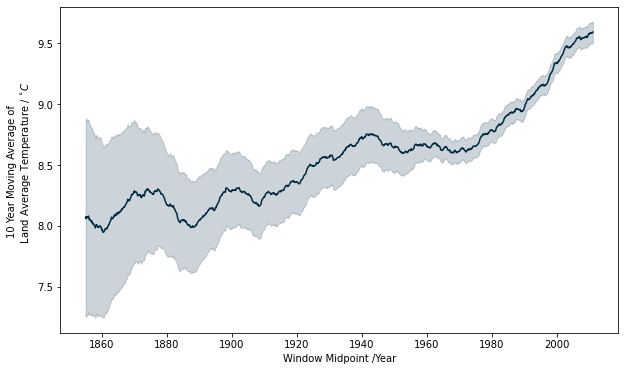

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ave_temp = np.mean(win_ave_temp,axis=1)
ave_unc = np.mean(win_ave_unc, axis=1)

lb = ave_temp - ave_unc
ub = ave_temp + ave_unc

ax.plot(time_midpoint,
    ave_temp,
    color=colours.durham.ink
    )
ax.fill_between(time_midpoint,
    lb,
    ub,
    color = colours.durham.ink,
    alpha=0.2
    )
ax.set_xlabel('Window Midpoint /Year')
ax.set_ylabel('10 Year Moving Average of \n \
    Land Average Temperature / $^{\circ}C$'
    );

## Predictions
Global temperatures provide an interesting case study for a further introduction to predictive modelling. There has already been substantial warming compared to the period from $1850-1900$. This period is set as a pre-industrial baseline{cite}`preindbaseline`. Further temperature rises will continue to increase the occurrence of extreme weather events and myriad other consequences, with an etire [IPCC](https://www.ipcc.ch/sr15/) report dedicated to the consequences of warming over $1.5^\circ C$. The special report on emission scenarios(SRES){cite}`SRES` produced by the IPCC in 2000, details multiple families of emission scenarios with their associated warming. 

These scenarios are developed using six independent models. Such models use economic driving forces and predict the consequences of changing macro-economic behaviour, for example, the percentage of fossil fuel used compared to renewables. 

These highly detailed models are not suitable for this section. Using $CO_2$ concentration, an overly simplistic model can be formed to determine the change in temperature over the next 80 years.
The three scenarios that will be investigated are inspired by Durham Universities' lack-lustre commitment to a net-zero commitment.
1. No reduction in emissions rates by 2030 and net-zero by 2050.
2. Net-zero by 2030, no further reductions
3. Net-zero by 2030, and then reducing total atmospheric carbon at the same rate it is currently produced. 
The relationship between $CO_2$ concentration used is:
```{math}
T(C) = T_0 + S \log_2(C/C_0).
```
Where $C$ is the concentration of $CO_2$ and $S$ is a fitted sensitivity factor.

## Current Warming trend 

In [7]:
## To do 
#- make a moving average dataframe function
def  moving_ave_frame(df, window):
    slv = sliding_window_view(df, window, axis=0)
    moving_averages = np.mean(slv, axis=2)
    ma_df = pd.DataFrame(moving_averages,columns=df.keys())
    return ma_df

def lb_ub(values, sigma):
    lb = values - sigma
    ub = values + sigma
    return lb, ub

In [8]:
trend_data = temp_data[temp_data['dt'] > 1960]
trend_ave = moving_ave_frame(trend_data,120)
lb, ub = lb_ub(trend_ave['LandAverageTemperature'], trend_ave['LandAverageTemperatureUncertainty'])


In [9]:
def P1(x, a0, a1):
    return a0 + a1*x



trend_fit, trend_error = curve_fit(P1, trend_ave['dt'], trend_ave['LandAverageTemperature'], sigma=trend_ave['LandAverageTemperatureUncertainty'])

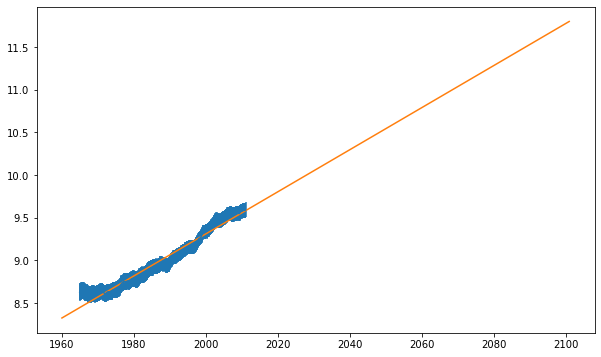

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
time = np.linspace(1960, 2101, 300)
plt.errorbar(trend_ave['dt'], trend_ave['LandAverageTemperature'], trend_ave['LandAverageTemperatureUncertainty'])
plt.plot(time, P1(time, *trend_fit))
